# Программа решения двумерного уравнения диффузии.

Введение 

Композитными материалами (композитами) называются материалы,
представляющие собой целенаправленным образом составленную
неоднородную структуру (композицию) из нескольких материалов с заметно
различающимися свойствами. При этом можно положительные свойства
одних составляющих (например, требуемые теплофизические свойства)
дополнять положительными свойствами (например, механическими) других
составляющих, то есть создавать материалы с заданными свойствами.

Математическое описание 

По определению, за эффективный коэффициент теплопроводности λэф композита принимается коэффициент теплопроводности некоторого однородного материала (возможно, и не существующего в природе), обеспечивающего при тех же заданных внешних условиях передачу такого же количества тепла, что и рассматриваемый композит.

![](image.png)  

Предполагая коэффициенты теплопроводности материалов, составляющих рассматриваемый композит, $ \lambda_k $ ($ k = 1, 2 $) не зависящими от температуры, для граничных условий 1 рода на обеих поверхностях стенок, изображенных на рис. 1, нетрудно получить следующие выражения для эффективного коэффициента теплопроводности при продольном (как на рис. 1а, $ \lambda_{\text{эф}}^{\parallel} $) и поперечном (как на рис. 1б, $ \lambda_{\text{эф}}^{\perp} $) расположениях слоев через теплопроводности составляющих и геометрические параметры композита:

$$
\lambda_{\text{эф}}^{\perp} = \frac{D_1 + D_2}{\frac{D_1}{\lambda_1} + \frac{D_2}{\lambda_2}},  (1)
$$

аналогично

$$
\lambda_{\text{эф}}^{\parallel} = \frac{\lambda_1 D_1 + \lambda_2 D_2}{D_1 + D_2}.  (2)
$$

Выражения (1), (2) определяют свойства композита через его структуру
(толщины отдельных слоев) и свойства составляющих его материалов. Но эти
выражения получены для стационарных граничных условий 1 рода для
конкретной структуры композита.

Постановка задачи

![](image1.png)

Рассмотрим плоскую стенку толщиной $ L $ (рис. 2), на поверхностях которой заданы следующие условия теплоотдачи: $ T_{\text{о.с}}^{(1)} $ и $ T_{\text{о.с}}^{(2)} $ — значения температуры окружающей среды; $ \alpha $ — коэффициент теплоотдачи, который будем полагать одинаковым для левой и правой поверхностей стенки. Пусть $ \eta $ — характерный вертикальный размер рассматриваемого участка стенки: для продольного расположения слоев (рис. 1а) он может быть выбран произвольно; для поперечного расположения (рис. 1б) должен быть кратным $ (D_1 + D_2) $.

Введем также среднюю плотность теплового потока вдоль оси $ 0x $:

$$
q_x = \frac{1}{\eta} \int_0^\eta q(x, y) \, dy,
\tag{3}
$$

и эффективные значения температуры $ T_w $ на левой («западной») и $ T_e $ на правой («восточной») поверхностях стенки.

С учетом определения $ \lambda_{\text{эф}} $ для стационарной теплопередачи можно записать следующую цепочку равенств:

$$
\frac{T_w - T_e}{L} \lambda_{\text{эф}} = q_x = \alpha (T_w - T_{\text{о.с}}^{(1)}) = \alpha (T_{\text{о.с}}^{(2)} - T_e),
\tag{4}
$$

откуда следует

$$
T_w - T_e = \frac{(T_{\text{о.с}}^{(1)} - T_{\text{о.с}}^{(2)})}{2} - \frac{q_x}{\alpha},
\tag{5}
$$

и, окончательно,

$$
\lambda_{\text{эф}} = \frac{L \cdot q_x}{T_w - T_e} = \frac{L \cdot q_x}{\frac{(T_{\text{о.с}}^{(1)} - T_{\text{о.с}}^{(2)})}{2} - \frac{q_x}{\alpha}}.
\tag{6}
$$

Это выражение определяет эффективный коэффициент теплопроводности через измеримые величины, характеризующие процесс теплопередачи.


Импорт модулей

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg, csr_matrix, lil_matrix  # ИЗМЕНЕНО: добавлены csr_matrix, lil_matrix
import random

Основная функция решения 

In [42]:
def Solve2D(Lx, Nx, Ly, Ny, GammaFun, CSourceFun, VSourceFun, CoefW, ValW, CoefE, ValE, CoefS, ValS, CoefN, ValN):
    
    # Ширина КО
    dx = Lx / Nx
    dy = Ly / Ny
    # грани КО
    XFace = np.linspace(0.0, Lx, Nx + 1)
    YFace = np.linspace(0.0, Ly, Ny + 1)
    # Площади граней
    dX = np.zeros(Nx)
    dX[:] = XFace[1:Nx + 1] - XFace[0:Nx]
    dY = np.zeros(Ny)
    dY[:] = YFace[1:Ny + 1] - YFace[0:Ny]
    
    # Создаем массив XP и YP с центрами КО
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx + 1]) / 2.0
    YP = np.zeros(Ny)  
    YP = (YFace[0:Ny] + YFace[1:Ny + 1]) / 2.0
    
    # объемы КО
    VolumeP = np.zeros(shape=(Nx, Ny), dtype=float)
    for ix in range(Nx):
        for iy in range(Ny):
            VolumeP[ix, iy] = dX[ix] * dY[iy]

    # Массив с обобщенным коэффициентом диффузии в центрах КО
    Gamma = np.zeros(shape=(Nx, Ny), dtype=float)
    for ix in range(Nx):
        for iy in range(Ny):
            Gamma[ix, iy] = GammaFun(XP[ix], YP[iy])
    
    CSource = np.zeros(shape=(Nx, Ny), dtype=float)
    VSource = np.zeros(shape=(Nx, Ny), dtype=float)
    
    for ix in range(Nx):
        for iy in range(Ny):
            CSource[ix, iy] = CSourceFun(XP[ix], YP[iy])
            VSource[ix, iy] = VSourceFun(XP[ix], YP[iy])
    
    # ИСПРАВЛЕНО: Используем разреженную матрицу LIL формата для эффективного построения
    A = lil_matrix((Nx * Ny, Nx * Ny), dtype=float)  # ИЗМЕНЕНО: было np.zeros(...)
    b = np.zeros(Nx * Ny, dtype=float)
    
    # перевод индексов в номер КО
    def k(i, j):
        return i + j * Nx
    
    # заполнение матрицы
    for ix in range(0, Nx):
        for iy in range(0, Ny):
            kp = k(ix, iy)
            b[kp] = b[kp] + CSource[ix, iy] * VSource[ix, iy] * VolumeP[ix, iy]
            A[kp, kp] = A[kp, kp] + CSource[ix, iy] * VolumeP[ix, iy]
            
            if ix == Nx - 1:
                # учитываем влияние правой границы
                anb = 2.0 * Gamma[ix, iy] * CoefE / (CoefE * dX[ix] + 2.0 * Gamma[ix, iy]) * dY[iy]
                A[kp, kp] = A[kp, kp] + anb
                b[kp] = b[kp] + anb * ValE
                
            else:
                # учитываем влияние правого КО
                ke = k(ix + 1, iy)
                anb = 2.0 * Gamma[ix, iy] * Gamma[ix + 1, iy] / (Gamma[ix, iy] * dX[ix + 1] + Gamma[ix + 1, iy] * dX[ix]) * dY[iy]
                A[kp, kp] = A[kp, kp] + anb
                A[kp, ke] = -anb
                A[ke, ke] = A[ke, ke] + anb
                A[ke, kp] = -anb 
            
            if ix == 0:
                # учитываем влияние левой границы
                anb = 2.0 * Gamma[ix, iy] * CoefW / (CoefW * dX[ix] + 2.0 * Gamma[ix, iy]) * dY[iy]
                A[kp, kp] = A[kp, kp] + anb
                b[kp] = b[kp] + anb * ValW

            # Задаем периодические ГУ
            if iy == Ny - 1:
                kn = k(ix, 0)
                anb = 2.0 * Gamma[ix, iy] * Gamma[ix, 0] / (Gamma[ix, iy] * dY[0] + Gamma[ix, 0] * dY[iy]) * dX[ix]
                A[kp, kp] = A[kp, kp] + anb
                A[kp, kn] = A[kp, kn] - anb
                A[kn, kn] = A[kn, kn] + anb
                A[kn, kp] = A[kn, kp] - anb           
                
            else:
                # учитываем влияние верхнего КО
                kn = k(ix, iy + 1)
                anb = 2.0 * Gamma[ix, iy] * Gamma[ix, iy + 1] / (Gamma[ix, iy] * dY[iy + 1] + Gamma[ix, iy + 1] * dY[iy]) * dX[ix]
                A[kp, kp] = A[kp, kp] + anb
                A[kp, kn] = -anb
                A[kn, kn] = A[kn, kn] + anb
                A[kn, kp] = -anb 
            
            if iy == 0:
                # учитываем влияние нижней границы
                anb = 2.0 * Gamma[ix, iy] * CoefS / (CoefS * dY[iy] + 2.0 * Gamma[ix, iy]) * dX[ix]
                A[kp, kp] = A[kp, kp] + anb
                b[kp] = b[kp] + anb * ValS         
            
                
    # ИСПРАВЛЕНО: Конвертируем в CSR формат для эффективного решения
    A_csr = A.tocsr()  # ИЗМЕНЕНО: добавлена конвертация в CSR формат
    Phi, info = linalg.gmres(A_csr, b)  # ИЗМЕНЕНО: используем A_csr вместо A
    
    Phi2D = np.zeros(shape=(Nx, Ny), dtype=float)
    for ix in range(0, Nx):
        for iy in range(0, Ny):
            kp = k(ix, iy)
            Phi2D[ix, iy] = Phi[kp]
   
    qsr = 0
    qsr_left = 0
    for k in range(Ny):
        qsr_left = qsr_left + (ValW - Phi2D[0, k]) / (1 / CoefW + dx / (2 * Gamma[0, k])) * dy  # левая граница

    qsr_left = qsr_left / Ly
    
    Lambdaeff = abs(-qsr_left * Lx / ((ValW - ValE) - (2 * qsr_left / CoefW)))
    
    return XP, XFace, YP, YFace, Phi2D, Gamma, Lambdaeff, qsr_left

# Задача 1

Параметры тестовой задачи 

In [43]:
# Количество вертикальных слоев
w = 4

# Размеры областей вещества 2 
delta1 = 1.0
delta2 = np.array([0.5, 2.0])

Nx = 32 #количество контрольных объемов
Ny = 16 #количество контрольных объемов
Lambda = 1.0 #коэффициент теплопроводности
coef = 50

# Bнутреннее тепловыделение
qv = 0.0

# Параметры на левой стенке
alphaLeft = np.array([1, 0.01, 100])
TLeft = 1.0

# Параметры на правой стенке
alphaRight = alphaLeft
TRight = 0.0   

# Параметры на верхней стенке
alphaUp = 0.0
TUp = 0.0

# Параметры на нижней стенке
alphaDown = 0.0
TDown = 0.0

Меняя delta2 и alpha построим графики

==================== Delta 2 = 0.5, alpha Left/Right = 1.0 ===================== 

Cредняя плотность теплового потока:  0.12968
Эфеективный коэффициент теплопроводности:  1.22568
Число Био=:  1.0


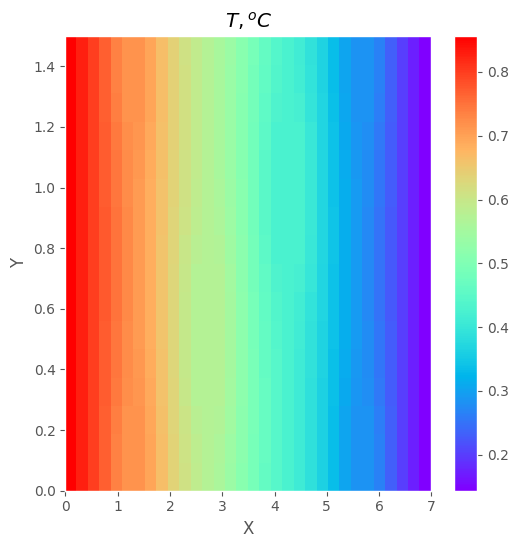

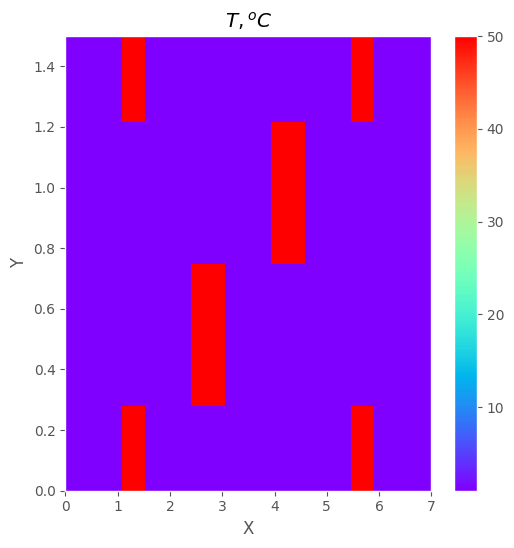

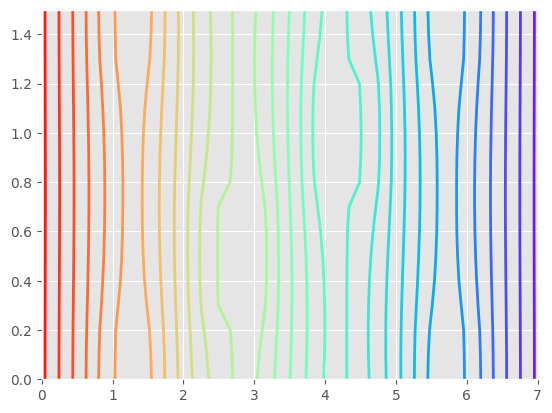

==================== Delta 2 = 0.5, alpha Left/Right = 0.01 ==================== 

Cредняя плотность теплового потока:  0.00765
Эфеективный коэффициент теплопроводности:  0.10095
Число Био=:  0.01


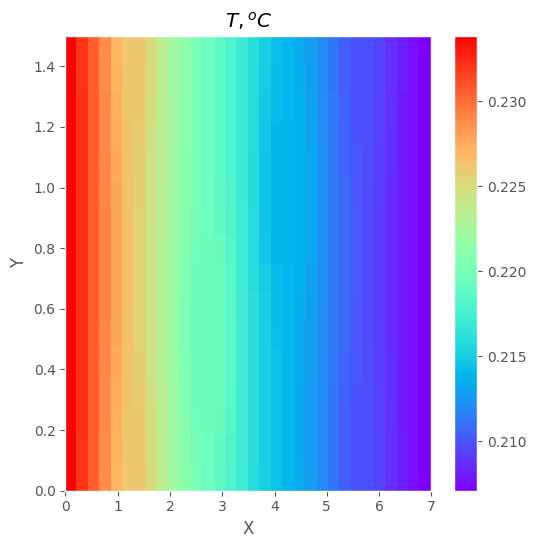

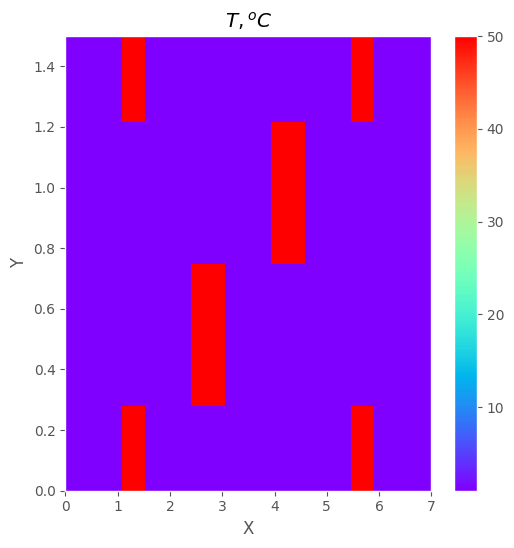

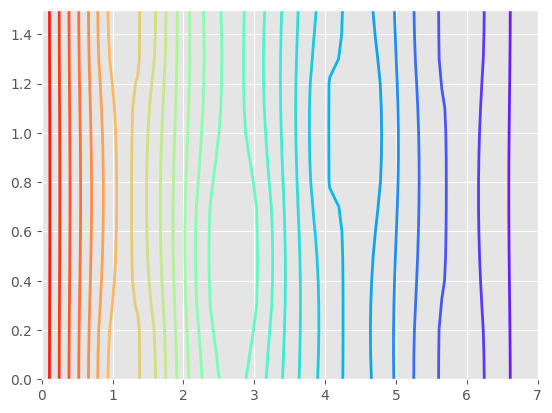

=================== Delta 2 = 0.5, alpha Left/Right = 100.0 ==================== 

Cредняя плотность теплового потока:  0.17466
Эфеективный коэффициент теплопроводности:  1.22689
Число Био=:  100.0


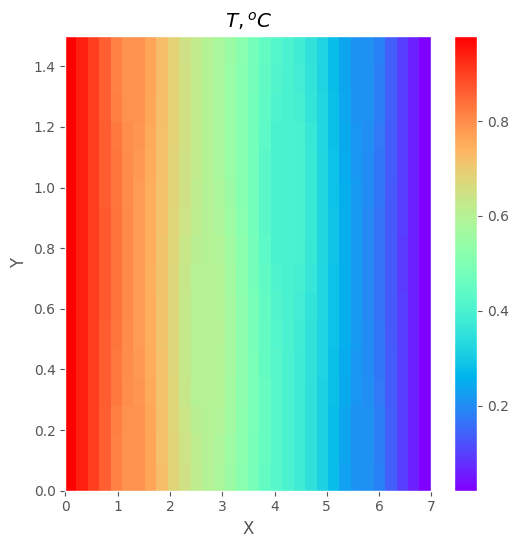

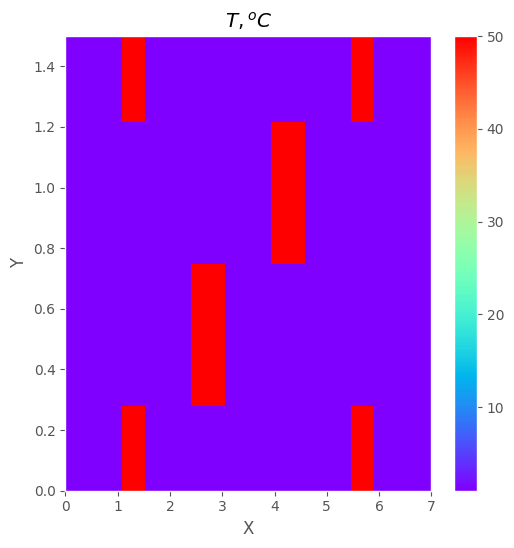

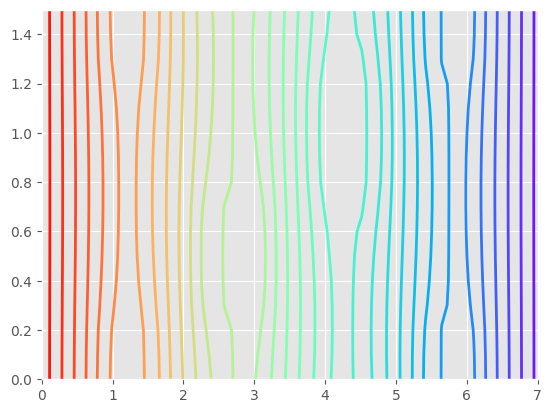

==================== Delta 2 = 2.0, alpha Left/Right = 1.0 ===================== 

Cредняя плотность теплового потока:  0.09806
Эфеективный коэффициент теплопроводности:  1.58577
Число Био=:  1.0


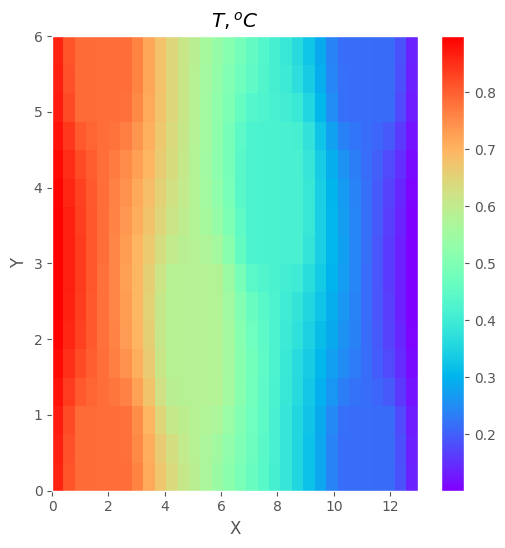

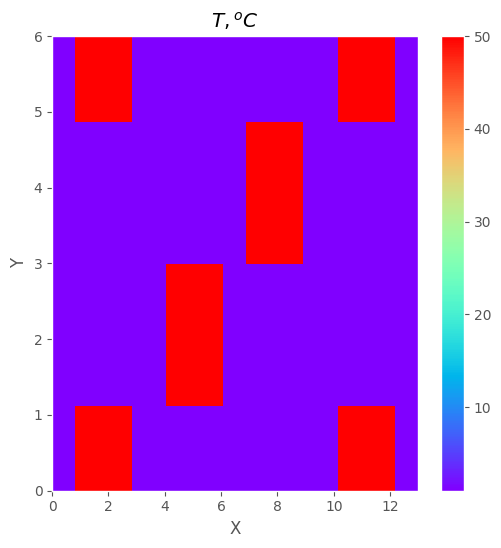

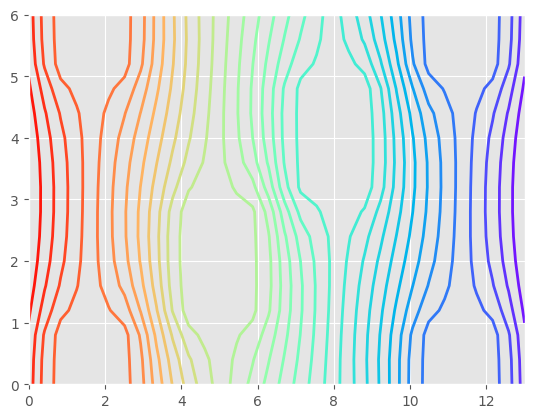

==================== Delta 2 = 2.0, alpha Left/Right = 0.01 ==================== 

Cредняя плотность теплового потока:  0.00505
Эфеективный коэффициент теплопроводности:  7.23863
Число Био=:  0.01


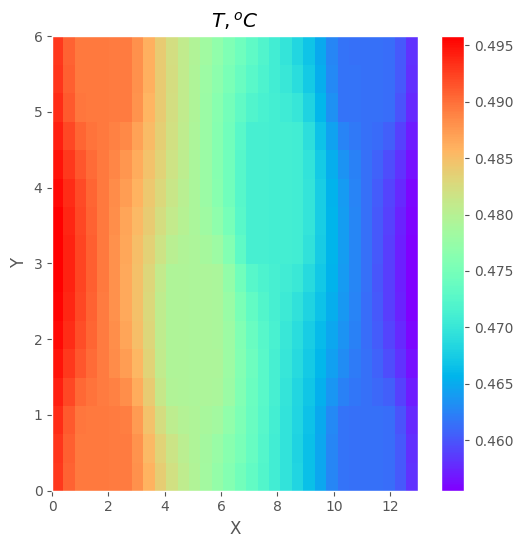

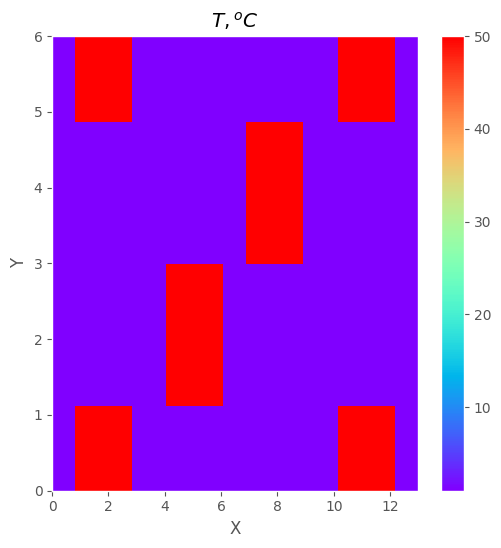

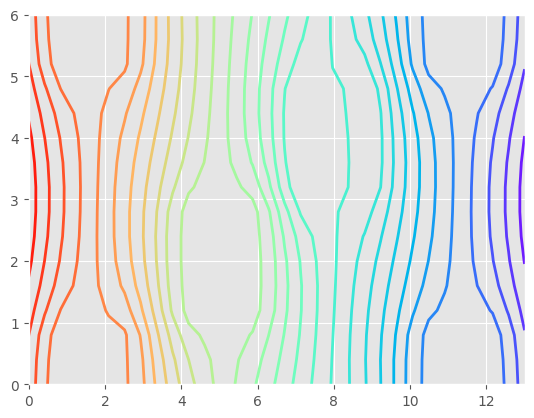

=================== Delta 2 = 2.0, alpha Left/Right = 100.0 ==================== 

Cредняя плотность теплового потока:  0.12259
Эфеективный коэффициент теплопроводности:  1.5976
Число Био=:  100.0


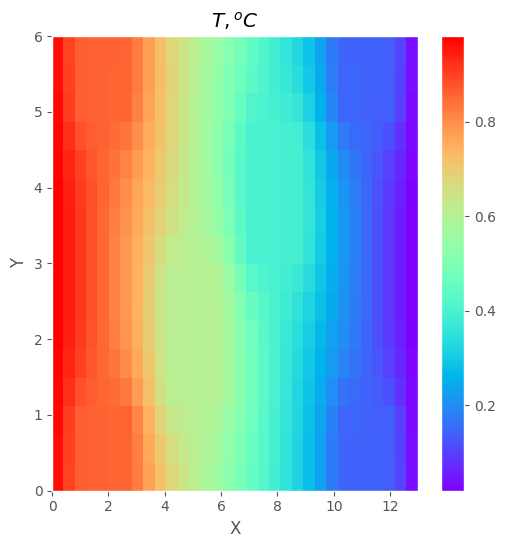

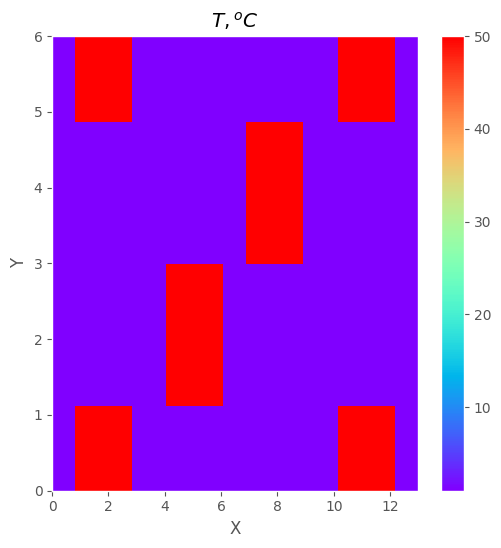

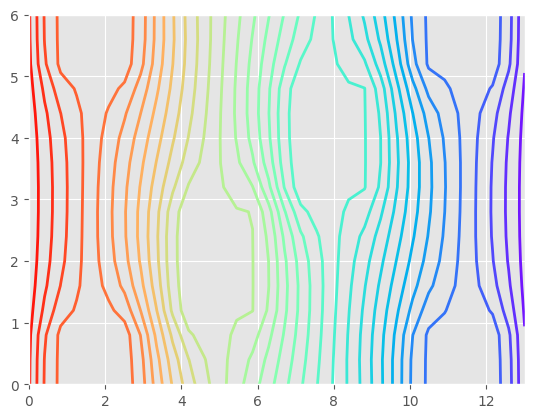

In [44]:
for d2 in delta2:
    for alpha in alphaLeft:

        text = f"Delta 2 = {d2}, alpha Left/Right = {alpha}"
        separator_length = 80  # Длина вашего разделителя
        print(f" {text} ".center(separator_length, '='), '\n')

        Lx = (w + 1) * delta1 + w * d2  # длина расчетной области
        Ly = (w - 1) * d2  # высота расчетной области
        
        # Функция расчета lamda в зависимости от попадания в область другого материала    
        def LambdaFun(x, y):
            lambda2 = Lambda
            if x >= delta1 and x <= delta1 + d2 and y >= 0 and y <= d2 / 2:
                lambda2 = coef * Lambda
            if x >= 2 * delta1 + d2 and x <= 2 * delta1 + 2 * d2 and y >= d2 / 2 and y <= d2 / 2 + d2:
                lambda2 = coef * Lambda
            if x >= 3 * delta1 + 2 * d2 and x <= 3 * delta1 + 3 * d2 and y >= d2 / 2 + d2 and y <= d2 / 2 + 2 * d2:
                lambda2 = coef * Lambda
            if x >= 4 * delta1 + 3 * d2 and x <= 4 * delta1 + 4 * d2 and y >= 0 and y <= d2 / 2:
                lambda2 = coef * Lambda
            if x >= delta1 and x <= delta1 + d2 and y >= d2 / 2 + 2 * d2 and y <= d2 / 2 + 2 * d2 + d2 / 2:
                lambda2 = coef * Lambda
            if x >= 4 * delta1 + 3 * d2 and x <= 4 * delta1 + 4 * d2 and y >= d2 / 2 + 2 * d2 and y <= d2 / 2 + 2 * d2 + d2 / 2:
                lambda2 = coef * Lambda   
                
            return lambda2
        
        def CSourceFun(x, y):
            return 1.0e-20

        def VSourceFun(x, y):
            return qv / 1.0e-20

        # Решение
        x, xf, y, yf, T, Gamma, Lambdaeff, qsr_left = Solve2D(
            Lx,
            Nx,
            Ly,
            Ny,
            LambdaFun,
            CSourceFun,
            VSourceFun,
            alpha,
            TLeft,
            alpha,
            TRight,
            alphaDown,
            TDown,
            alphaUp,
            TUp)
        print("Cредняя плотность теплового потока: ", round(qsr_left, 5))
        print("Эфеективный коэффициент теплопроводности: ", round(Lambdaeff, 5))
        print("Число Био=: ", alpha * delta1 / Lambda)

        # Строим графики
        fig = plt.figure('fig1', figsize=(150.0 / 25.4, 150.0 / 25.4))
        plt.pcolor(xf, yf, T.T, cmap='rainbow')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title("$T,^oC$")
        plt.colorbar()
        plt.xlim(0.0, Lx)
        plt.ylim(0.0, Ly)
        plt.show()
        
        # Строим графики
        fig = plt.figure('fig1', figsize=(150.0 / 25.4, 150.0 / 25.4))
        plt.pcolor(xf, yf, Gamma.T, cmap='rainbow')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title("$T,^oC$")
        plt.colorbar()
        plt.xlim(0.0, Lx)
        plt.ylim(0.0, Ly)
        plt.show()

        plt.contour(T.T, Nx, cmap='rainbow', extent=(0.0, Lx, 0.0, Ly), linewidths=2)
        plt.show()

# Задача 2 

Параметры тестовой задачи

In [45]:
#Параметры тестовой задачи
w = 4

# Размеры области
delta1 = 1.0
delta2 = 1.0

# Длина расчетной области
Lx = 7.0 
# Количество контрольных объемов
Nx = [10, 50, 100] 
# Граничное значение вероятности
p = 0.85

# Высота расчетной области
Ly = Lx
# Количество контрольных объемов
Ny = Nx 

# Коэффициент теплопроводности
lambda1 = 1.0 
lambda2 = 10.0

# Внутреннее тепловыделение
qv = 0.0 

# Параметры на левой стенке
alphaLeft = 1.0
TLeft = 1.0

# Параметры на правой стенке
alphaRight = alphaLeft
TRight = 0.0   

# Параметры на верхней стенке
alphaUp = 0.0
TUp = 0.0

# Параметры на нижней стенке
alphaDown = 0.0
TDown = 0.0

Решение

============================================= Nx = 10 ============================================== 

средний эфеективный коэффициент теплопроводности 0.4912133606369274


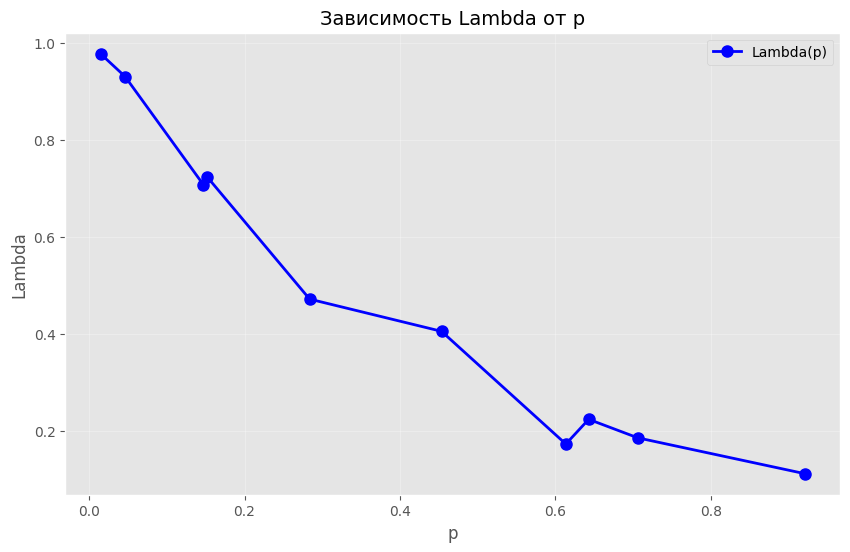

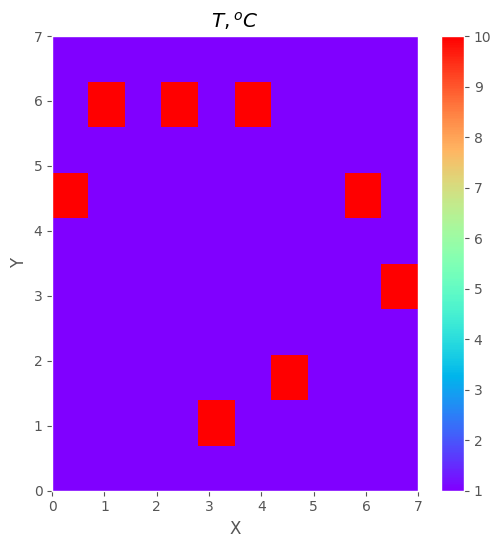

============================================= Nx = 50 ============================================== 

средний эфеективный коэффициент теплопроводности 0.39033909796984934


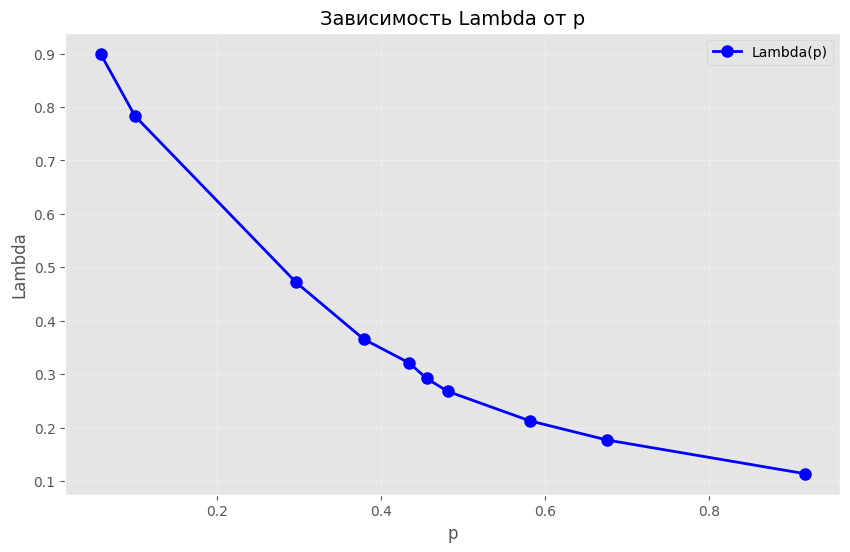

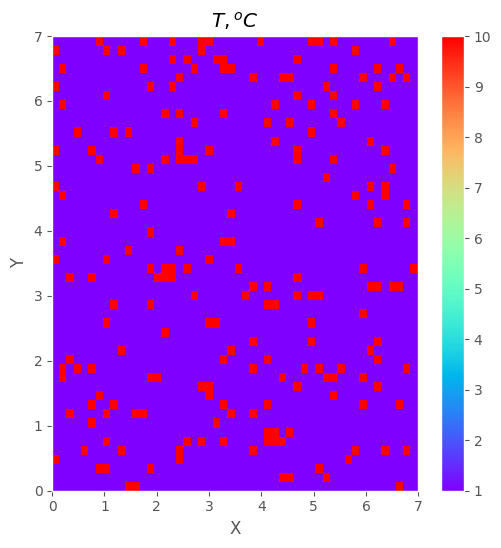

In [ ]:
for nx in Nx:

    ny = nx
    n = 10 

    result = []

    values_of_p = sorted(np.random.uniform(0, 1, 10))

    for value in values_of_p:
        for i in range(10):
            counter = 0

            def LambdaFun(x,y):
                pk = random.uniform(0, 1) #??????????
                if pk <= value:
                    lam = lambda1
                else:
                    lam = lambda2 
                return lam
            
            def CSourceFun(x,y):
                return 1.0e-20

            def VSourceFun(x,y):
                return qv / 1.0e-20
            
            x, xf, y, yf, T, Gamma, Lambdaeff, qsr_left = Solve2D(
            Lx,
            nx,
            Ly,
            ny,
            LambdaFun,
            CSourceFun,
            VSourceFun,
            alpha,
            TLeft,
            alpha,
            TRight,
            alphaDown,
            TDown,
            alphaUp,
            TUp)

            counter += Lambdaeff
        
        mean_values = counter / 10
        result.append(mean_values)
   
    text = f"Nx = {nx}"
    separator_length = 100  # Длина вашего разделителя
    print(f" {text} ".center(separator_length, '='), '\n')

    print("средний эфеективный коэффициент теплопроводности", np.mean(result))

    plt.figure(figsize=(10, 6))
    plt.plot(values_of_p, result, 'bo-', linewidth=2, markersize=8, label='Lambda(p)')
    plt.xlabel('p', fontsize=12)
    plt.ylabel('Lambda', fontsize=12)
    plt.title('Зависимость Lambda от p', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    fig = plt.figure('fig1', figsize=(150.0 / 25.4, 150.0 / 25.4))
    plt.pcolor(xf, yf, Gamma.T, cmap='rainbow')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("$T,^oC$")
    plt.colorbar()
    plt.xlim(0.0, Lx)
    plt.ylim(0.0, Ly)
    plt.show()